## Data Mining Techniques
### COVID-19 data
Kimberley Boersma (2572145), Neil Mizzi (2674737), Selma Muhammad (2578081)

In [1]:
# Imports
import os
import pandas as pd
import csv
import kaggle

# other imports
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from copy import copy
import seaborn as sns
from scipy.stats import norm
import matplotlib.dates as mdates
# import matplotlib.colors as mcolors
# import random
# import math
# import time
# from sklearn.linear_model import LinearRegression, BayesianRidge
# from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
# from sklearn.svm import SVR
from datetime import date, datetime
from dateutil.parser import parse
# import us
# import operator 
# plt.style.use('fivethirtyeight')
%matplotlib inline 

d:\dropbox\projects\results\venv\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


# Covid Tracking Dataset (w/ hospitalised data)

Source: https://covidtracking.com/

## Step 1: Load and Clean the Data

In [2]:
all_cases = pd.read_csv('https://covidtracking.com/api/v1/states/daily.csv')

# Delete unecessary rows
for row in ['negative', 'pending', 'hash', 'negativeIncrease', 'totalTestResults', 'totalTestResultsIncrease', 'dateChecked', 'fips', 'inIcuCumulative', 'onVentilatorCumulative', 'total', 'posNeg', 'deathIncrease', 'hospitalizedIncrease', 'positiveIncrease']:
    del all_cases[row]

# TODO missing values
#      Do we get avg or missing values, or predict them?
#      See https://developerzen.com/data-mining-handling-missing-values-the-database-bd2241882e72

for i, row in all_cases.iterrows():
    # Set Dates
    s = str(row['date'])
    all_cases.at[i, 'date'] = date(year=int(s[0:4]), month=int(s[4:6]), day=int(s[6:8]))
    

# Missing death figures means no death reports yet
# These are set to 0
for i, row in all_cases.iterrows():
    if np.isnan(row['death']):
        all_cases.at[i, 'death'] = 0

## Missing values: Retrieving from other datasets or through merging columns (or both)

The following will be done:
- **Active Cases**: Retrieved from JHU dataset and calculating $active = pos-dead-recovered$
- **Beds per State**: Retrieved from External Datasets

In [3]:
# TODO Replace active cases with JHU and/or regression model (Selma)
all_cases['active'] = all_cases['positive'] - all_cases['recovered'] - all_cases['death']
# change location of 'active' column
cols = list(all_cases)
cols.insert(3, cols.pop(cols.index('active')))
all_cases = all_cases.loc[:, cols]

In [4]:
# Load datasets for US population and Hospital beds per 1000
us_population = pd.read_csv('data/us_population.csv')
hosp_beds = pd.read_csv('data/hospital_beds.csv')
state_abbrev = pd.read_csv('data/us_state_names.csv')

# add state abbreviations to us_population and hospital beds dataframe
for state in state_abbrev['State'].tolist():
    # store state abbreviation in variable
    abbrev = state_abbrev.loc[state_abbrev['State'] == state, 'Abbreviation'].tolist()[0]
    # add abbrev to new column 'Abbreviation' in us_population df
    us_population.loc[us_population['State'] == state, 'Abbreviation'] = abbrev
    # add abbrev to new column in hosp_beds df
    hosp_beds.loc[hosp_beds['Location'] == state, 'Abbreviation'] = abbrev
    
# change order of columns of us_population
cols = list(us_population)
cols.insert(2, cols.pop(cols.index('Abbreviation')))
us_population = us_population.loc[:, cols]

# drop unnecessary columns of us_population
us_population = us_population.drop(columns=['rank', 'Growth', 'Pop2018', 'Pop2010', 'growthSince2010', 'Percent', 'density'])

# drop unnecessary columns of hosp_beds
hosp_beds = hosp_beds.drop(columns=['Location', 'State/Local Government', 'Non-Profit', 'For-Profit'])

# change order of columns of hosp_beds
cols = list(hosp_beds)
cols.insert(0, cols.pop(cols.index('Abbreviation')))
hosp_beds = hosp_beds.loc[:, cols]

In [5]:
us_population.head()

,State,Abbreviation,Pop
0,Alabama,AL,4908621
1,Alaska,AK,734002
2,Arizona,AZ,7378494
3,Arkansas,AR,3038999
4,California,CA,39937489


In [6]:
hosp_beds.head()

,Abbreviation,Total
0,NaN,2.4
1,AL,3.1
2,AK,2.2
3,AZ,1.9
4,AR,3.2


In [7]:
# filter out non-existing states like 'AS'
all_cases = all_cases[all_cases['state'].isin(state_abbrev['Abbreviation'].tolist())]

In [8]:
# see what filtered dataframe looks like
all_cases.head()

,date,state,positive,active,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,onVentilatorCurrently,recovered,dataQualityGrade,lastUpdateEt,death,hospitalized
0,2020-05-09,AK,378.0,50.0,8.0,NaN,NaN,NaN,318.0,C,5/9/2020 00:00,10.0,NaN
1,2020-05-09,AL,9567.0,NaN,NaN,1228.0,NaN,NaN,NaN,B,5/9/2020 00:00,388.0,1228.0
2,2020-05-09,AR,3747.0,691.0,64.0,471.0,NaN,14.0,2968.0,B,5/9/2020 10:15,88.0,471.0
4,2020-05-09,AZ,10960.0,7744.0,739.0,1514.0,296.0,186.0,2684.0,A+,5/9/2020 00:00,532.0,1514.0
5,2020-05-09,CA,64561.0,NaN,4538.0,NaN,1349.0,NaN,NaN,B,5/9/2020 14:00,2678.0,NaN


In [9]:
# check which states have 0 positive cases
all_cases.loc[all_cases['positive'] == 0]

,date,state,positive,active,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,onVentilatorCurrently,recovered,dataQualityGrade,lastUpdateEt,death,hospitalized
3022,2020-03-17,WV,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3/16/2020 00:00,0.0,NaN
3078,2020-03-16,WV,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3/16/2020 15:53,0.0,NaN
3129,2020-03-15,WV,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3/14/2020 00:00,0.0,NaN
3180,2020-03-14,WV,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3/13/2020 00:00,0.0,NaN
3195,2020-03-13,ID,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3/13/2020 08:00,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3580,2020-03-05,NE,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3585,2020-03-05,OH,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3588,2020-03-05,SC,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3591,2020-03-05,VA,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


In [10]:
# Split dataframes by date
df_split_by_date = dict(tuple(all_cases.groupby('date')))

# Split dataframes by state
df_split_by_state = dict(tuple(all_cases.groupby('state')))

In [11]:
# merge dataframes us_population and all_cases
df_merge_uspop = all_cases.merge(us_population, how='left', left_on='state', right_on='Abbreviation')
df_merge_uspop = df_merge_uspop.drop(columns=['Abbreviation'])
df_merge_uspop = df_merge_uspop.rename(columns={'Pop': 'population'})

# change location of 'population' column
cols = list(df_merge_uspop)
cols.insert(2, cols.pop(cols.index('population')))
df_merge_uspop = df_merge_uspop.loc[:, cols]

# merge dataframes hosp_beds and df_merge_uspop
df_merge_hosp = df_merge_uspop.merge(hosp_beds, how='left', left_on='state', right_on='Abbreviation')
df_merge_hosp = df_merge_hosp.drop(columns=['Abbreviation'])
all_cases = df_merge_hosp.rename(columns={'Total': 'bedsPerThousand'})

In [12]:
all_cases.head()

,date,state,population,positive,active,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,onVentilatorCurrently,recovered,dataQualityGrade,lastUpdateEt,death,hospitalized,State,bedsPerThousand
0,2020-05-09,AK,734002,378.0,50.0,8.0,NaN,NaN,NaN,318.0,C,5/9/2020 00:00,10.0,NaN,Alaska,2.2
1,2020-05-09,AL,4908621,9567.0,NaN,NaN,1228.0,NaN,NaN,NaN,B,5/9/2020 00:00,388.0,1228.0,Alabama,3.1
2,2020-05-09,AR,3038999,3747.0,691.0,64.0,471.0,NaN,14.0,2968.0,B,5/9/2020 10:15,88.0,471.0,Arkansas,3.2
3,2020-05-09,AZ,7378494,10960.0,7744.0,739.0,1514.0,296.0,186.0,2684.0,A+,5/9/2020 00:00,532.0,1514.0,Arizona,1.9
4,2020-05-09,CA,39937489,64561.0,NaN,4538.0,NaN,1349.0,NaN,NaN,B,5/9/2020 14:00,2678.0,NaN,California,1.8


In [13]:
# Calculate the total beds, and add the column
all_cases['total_beds'] = all_cases['population'] / 1000 * all_cases['bedsPerThousand']
all_cases

,date,state,population,positive,active,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,onVentilatorCurrently,recovered,dataQualityGrade,lastUpdateEt,death,hospitalized,State,bedsPerThousand,total_beds
0,2020-05-09,AK,734002,378.0,50.0,8.0,NaN,NaN,NaN,318.0,C,5/9/2020 00:00,10.0,NaN,Alaska,2.2,1614.8044
1,2020-05-09,AL,4908621,9567.0,NaN,NaN,1228.0,NaN,NaN,NaN,B,5/9/2020 00:00,388.0,1228.0,Alabama,3.1,15216.7251
2,2020-05-09,AR,3038999,3747.0,691.0,64.0,471.0,NaN,14.0,2968.0,B,5/9/2020 10:15,88.0,471.0,Arkansas,3.2,9724.7968
3,2020-05-09,AZ,7378494,10960.0,7744.0,739.0,1514.0,296.0,186.0,2684.0,A+,5/9/2020 00:00,532.0,1514.0,Arizona,1.9,14019.1386
4,2020-05-09,CA,39937489,64561.0,NaN,4538.0,NaN,1349.0,NaN,NaN,B,5/9/2020 14:00,2678.0,NaN,California,1.8,71887.4802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3377,2020-01-26,WA,7797095,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Washington,1.7,13255.0615
3378,2020-01-25,WA,7797095,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Washington,1.7,13255.0615
3379,2020-01-24,WA,7797095,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Washington,1.7,13255.0615
3380,2020-01-23,WA,7797095,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Washington,1.7,13255.0615


In [14]:
# change abbreviations to state names
all_cases = all_cases.rename(columns={'state': 'abbrev'})
all_cases = all_cases.rename(columns={'State': 'state'})

In [15]:
# change location of 'state' column
cols = list(all_cases)
cols.insert(1, cols.pop(cols.index('state')))
all_cases = all_cases.loc[:, cols]

In [16]:
all_cases

,date,state,abbrev,population,positive,active,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,onVentilatorCurrently,recovered,dataQualityGrade,lastUpdateEt,death,hospitalized,bedsPerThousand,total_beds
0,2020-05-09,Alaska,AK,734002,378.0,50.0,8.0,NaN,NaN,NaN,318.0,C,5/9/2020 00:00,10.0,NaN,2.2,1614.8044
1,2020-05-09,Alabama,AL,4908621,9567.0,NaN,NaN,1228.0,NaN,NaN,NaN,B,5/9/2020 00:00,388.0,1228.0,3.1,15216.7251
2,2020-05-09,Arkansas,AR,3038999,3747.0,691.0,64.0,471.0,NaN,14.0,2968.0,B,5/9/2020 10:15,88.0,471.0,3.2,9724.7968
3,2020-05-09,Arizona,AZ,7378494,10960.0,7744.0,739.0,1514.0,296.0,186.0,2684.0,A+,5/9/2020 00:00,532.0,1514.0,1.9,14019.1386
4,2020-05-09,California,CA,39937489,64561.0,NaN,4538.0,NaN,1349.0,NaN,NaN,B,5/9/2020 14:00,2678.0,NaN,1.8,71887.4802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3377,2020-01-26,Washington,WA,7797095,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.7,13255.0615
3378,2020-01-25,Washington,WA,7797095,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.7,13255.0615
3379,2020-01-24,Washington,WA,7797095,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.7,13255.0615
3380,2020-01-23,Washington,WA,7797095,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.7,13255.0615


- Load and clean JHU data
- Merge JHU dataset with main dataset

In [17]:
# This cell takes some time, as it needs to connect to Kaggle Servers to retrieve data
kaggle.api.authenticate()
kaggle.api.dataset_download_files('benhamner/jhucovid19', path='./kaggle/input/jhucovid19/', unzip=True)

In [18]:
# Get Time-Series Data of cases as Pandas DataFrame
dir_jhu = './kaggle/input/jhucovid19/csse_covid_19_data/csse_covid_19_daily_reports'

df_list = []
for dirname, _, files in os.walk(dir_jhu):
    for file in files:
        if 'gitignore' not in file and 'README' not in file:
            full_dir = os.path.join(dirname, file)
            #print(full_dir)
            df_list.append(pd.read_csv(full_dir))
jhu_df = pd.concat(df_list, axis=0, ignore_index=True, sort=True)

# Combine Last Update with Last_Update
jhu_df['LastUpdate'] = jhu_df['Last_Update'].combine_first(jhu_df['Last Update'])

# Format dates with parser
for i, row in jhu_df.iterrows():
    # update dates
    jhu_df.at[i, 'LastUpdate'] = parse(jhu_df.at[i, 'LastUpdate']).date()

# Combine Country/Region with Country_Region
jhu_df['CountryRegion'] = jhu_df['Country/Region'].combine_first(jhu_df['Country_Region'])

# Retrieve only US data
jhu_df = jhu_df[jhu_df['CountryRegion']=='US']

# Combine Province/State with Province_State
jhu_df['ProvinceState'] = jhu_df['Province/State'].combine_first(jhu_df['Province_State'])

# Drop unnecessary columns
jhu_df = jhu_df.drop(['Admin2', 'Lat', 'Latitude', 'Long_', 'Longitude', 'Combined_Key', 'Country/Region',
                      'Country_Region', 'Province/State', 'Province_State',
                      'Last Update', 'Last_Update', 'FIPS'], axis=1)

# Change column order
cols = list(jhu_df)
cols.insert(0, cols.pop(cols.index('CountryRegion')))
cols.insert(1, cols.pop(cols.index('ProvinceState')))
cols.insert(2, cols.pop(cols.index('LastUpdate')))
jhu_df = jhu_df.loc[:, cols]

# Change region to known US states
import us
state_abbrs = []
for state in us.states.STATES:
    state_abbrs.append(state.abbr)

for i, row in jhu_df.iterrows():
    for j in state_abbrs:
        if j in jhu_df.at[i, 'ProvinceState']:
            jhu_df.at[i, 'ProvinceState'] = us.states.lookup(j).name
        if jhu_df.at[i, 'ProvinceState'] == 'Washington, D.C.':
            jhu_df.at[i, 'ProvinceState'] = 'District of Columbia'

# Filter out unknown states
jhu_df = jhu_df[jhu_df['ProvinceState'].isin(list(all_cases.state.unique()))]

# Merge-sum rows with same date and State
jhu_df = jhu_df.groupby(['LastUpdate', 'ProvinceState']).agg(
    {
        'Active': sum,
        'Confirmed': sum,
        'Deaths': sum,
        'Recovered': sum
    }
).reset_index()

jhu_df

,LastUpdate,ProvinceState,Active,Confirmed,Deaths,Recovered
0,2020-01-22,Washington,0.0,1.0,0.0,0.0
1,2020-01-23,Washington,0.0,1.0,0.0,0.0
2,2020-01-24,Washington,0.0,1.0,0.0,0.0
3,2020-01-25,Illinois,0.0,1.0,0.0,0.0
4,2020-01-25,Washington,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...
3105,2020-05-09,Virginia,21530.0,22342.0,812.0,0.0
3106,2020-05-09,Washington,15483.0,16388.0,905.0,0.0
3107,2020-05-09,West Virginia,1271.0,1323.0,52.0,0.0
3108,2020-05-09,Wisconsin,9206.0,9590.0,384.0,0.0


In [19]:
# Now that we have the JHU dataset relatively cleaned
# we can go ahead and merge its data with our main dataset

for i, row in all_cases.iterrows():
    last_update = all_cases.at[i, 'date']
    state = all_cases.at[i, 'state']
    matching_row = jhu_df[jhu_df['ProvinceState'] == state]
    matching_row = matching_row[matching_row['LastUpdate'] == last_update].reset_index()

    if len(matching_row.values) > 0:
        #all_cases.at[i, 'positive'] = matching_row['Confirmed'].values[0]
        all_cases.at[i, 'active'] = matching_row['Active'].values[0]
        #all_cases.at[i, 'recovered'] = matching_row['Recovered'].values[0]   --- JHU was inconsistent, therefore removed
        #all_cases.at[i, 'death'] = matching_row['Deaths'].values[0]

    # Replace unknown recovery numbers with 0
    if np.isnan(row['recovered']):
        all_cases.at[i, 'recovered'] = 0

    if all_cases.at[i, 'active'] == 0 or np.isnan(row['active']):
        positive = all_cases.at[i, 'positive']
        recovered = all_cases.at[i, 'recovered']
        dead = all_cases.at[i, 'death']
        all_cases.at[i, 'active'] = positive - recovered - dead

all_cases

,date,state,abbrev,population,positive,active,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,onVentilatorCurrently,recovered,dataQualityGrade,lastUpdateEt,death,hospitalized,bedsPerThousand,total_beds
0,2020-05-09,Alaska,AK,734002,378.0,367.0,8.0,NaN,NaN,NaN,318.0,C,5/9/2020 00:00,10.0,NaN,2.2,1614.8044
1,2020-05-09,Alabama,AL,4908621,9567.0,9179.0,NaN,1228.0,NaN,NaN,0.0,B,5/9/2020 00:00,388.0,1228.0,3.1,15216.7251
2,2020-05-09,Arkansas,AR,3038999,3747.0,3659.0,64.0,471.0,NaN,14.0,2968.0,B,5/9/2020 10:15,88.0,471.0,3.2,9724.7968
3,2020-05-09,Arizona,AZ,7378494,10960.0,10009.0,739.0,1514.0,296.0,186.0,2684.0,A+,5/9/2020 00:00,532.0,1514.0,1.9,14019.1386
4,2020-05-09,California,CA,39937489,64561.0,61883.0,4538.0,NaN,1349.0,NaN,0.0,B,5/9/2020 14:00,2678.0,NaN,1.8,71887.4802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3377,2020-01-26,Washington,WA,7797095,1.0,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,1.7,13255.0615
3378,2020-01-25,Washington,WA,7797095,1.0,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,1.7,13255.0615
3379,2020-01-24,Washington,WA,7797095,1.0,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,1.7,13255.0615
3380,2020-01-23,Washington,WA,7797095,1.0,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,1.7,13255.0615


In [20]:
# Save formatted dataset offline in case of disaster
all_cases.to_csv('all_cases.csv')

In [21]:
# convert date to datetime format
all_cases['date'] = pd.to_datetime(all_cases['date'])

# Step 2: Exploratory Data Analysis (EDA)

## A. Investigating the Dataset

### Used sources:
https://medium.com/@gio.amorim/data-exploration-for-regression-analysis-821ee0bfc724


In [22]:
# TODO fix dates in timeseries plots
# TODO make the transitions between all the plots smooth/into a coherent story
# TODO B. Check for regression 
# TODO rounding up the numbers
# TODO which timeseries plots do we need?
# TODO add legend to histogram plot
# TODO:add sns pairplots? They're very aesthetic 
# See other TODO's in the code blocks

# An Exploratory data analysis of the US dataset
# 1. Basic triad of the dataset: investigating data types and number of rows per column


In [23]:
cases_info = all_cases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3382 entries, 0 to 3381
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    3382 non-null   datetime64[ns]
 1   state                   3382 non-null   object        
 2   abbrev                  3382 non-null   object        
 3   population              3382 non-null   int64         
 4   positive                3382 non-null   float64       
 5   active                  3382 non-null   float64       
 6   hospitalizedCurrently   1395 non-null   float64       
 7   hospitalizedCumulative  1434 non-null   float64       
 8   inIcuCurrently          709 non-null    float64       
 9   onVentilatorCurrently   576 non-null    float64       
 10  recovered               3382 non-null   float64       
 11  dataQualityGrade        764 non-null    object        
 12  lastUpdateEt            3009 non-null   object  

Conclusion: onVentilatorCurrently, inICUCurrently and Hospitalized and HospitalizationCumulative contain many NaN values. 
we further inspect the NaN values by printing the tail of the dataset.

In [24]:
all_cases.tail(10)

,date,state,abbrev,population,positive,active,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,onVentilatorCurrently,recovered,dataQualityGrade,lastUpdateEt,death,hospitalized,bedsPerThousand,total_beds
3372,2020-01-31,Washington,WA,7797095,1.0,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,1.7,13255.0615
3373,2020-01-30,Washington,WA,7797095,1.0,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,1.7,13255.0615
3374,2020-01-29,Washington,WA,7797095,1.0,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,1.7,13255.0615
3375,2020-01-28,Washington,WA,7797095,1.0,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,1.7,13255.0615
3376,2020-01-27,Washington,WA,7797095,1.0,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,1.7,13255.0615
3377,2020-01-26,Washington,WA,7797095,1.0,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,1.7,13255.0615
3378,2020-01-25,Washington,WA,7797095,1.0,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,1.7,13255.0615
3379,2020-01-24,Washington,WA,7797095,1.0,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,1.7,13255.0615
3380,2020-01-23,Washington,WA,7797095,1.0,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,1.7,13255.0615
3381,2020-01-22,Washington,WA,7797095,1.0,1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,1.7,13255.0615


The NaN values may indicate that there were no to few Covid-19 patients at these date points.
We further analyse the statistical values of the dataset columns. 

In [25]:
all_cases.describe()
# TODO rounding up the numbers

,population,positive,active,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,onVentilatorCurrently,recovered,death,hospitalized,bedsPerThousand,total_beds
count,3.382000e+03,3382.000000,3382.000000,1395.000000,1434.000000,709.000000,576.000000,3382.000000,3382.000000,1434.000000,3382.000000,3382.000000
mean,6.578035e+06,9240.038439,8564.584861,1448.378495,2394.546722,640.069111,326.083333,1039.633649,442.975163,2394.546722,2.618214,15850.527727
std,7.394240e+06,29302.074673,26585.783930,2751.375388,8803.097933,982.728619,427.660780,4811.935806,1701.503544,8803.097933,0.743740,16171.236932
min,5.670250e+05,0.000000,0.000000,4.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.600000,1318.928100
25%,1.778070e+06,109.750000,106.000000,95.000000,94.000000,98.000000,30.000000,0.000000,1.000000,94.000000,2.100000,3773.952000
50%,4.572438e+06,1226.000000,1117.500000,393.000000,407.000000,175.000000,141.000000,0.000000,27.000000,407.000000,2.500000,11557.920400
75%,7.797095e+06,6110.750000,5796.750000,1550.500000,1184.750000,924.000000,503.250000,268.500000,206.000000,1184.750000,3.100000,19124.737000
max,3.993749e+07,333122.000000,356899.000000,18825.000000,72255.000000,5225.000000,2425.000000,58950.000000,21271.000000,72255.000000,4.800000,71887.480200


## B. Graphical Exploratory Analysis

Plotting histograms, scatterplots and boxplots to assess the distribution of the dataset. 

In [26]:
# Omitting the categorical (states/abbreviations) and time columns 
# There must be an easier way for you, but this was the easiest way I could think of
plot_df = all_cases[['population', 'positive', 'active', 'hospitalizedCurrently', 'hospitalizedCumulative', 'inIcuCurrently', 'onVentilatorCurrently', 'recovered', 'death', 'hospitalized', 'bedsPerThousand', 'total_beds']]

Text(0.5, 1.0, 'Number of USA Patients Currently in ICU')

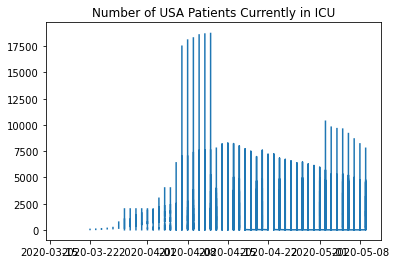

In [27]:
# Timeseries plot
plt.plot(all_cases.date, all_cases.hospitalizedCurrently)
plt.title('Number of USA Patients Currently in ICU')
# TODO change the X-axis to chip the year
# TODO which timeseries plots do we need?
# TODO how to temporarily remove the outliers?

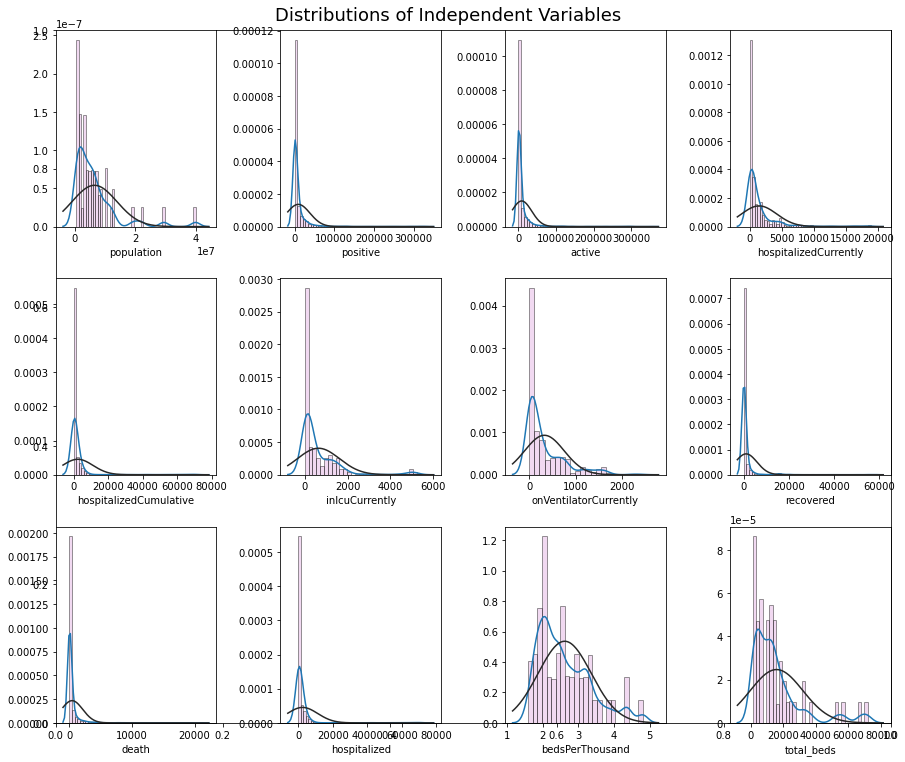

In [28]:
# Plotting histograms to gain insight of the distribution shape, skewness and scale
fig, ax = plt.subplots(figsize = (13, 11))
for i, col in enumerate(plot_df.columns):
    ax=fig.add_subplot(3, 4, i+1) 
    sns.distplot(plot_df[col], fit=norm, hist_kws=dict(color='plum', edgecolor="k", linewidth=1), ax=ax)
    #plt.legend() TODO add labels
    plt.suptitle('Distributions of Independent Variables', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

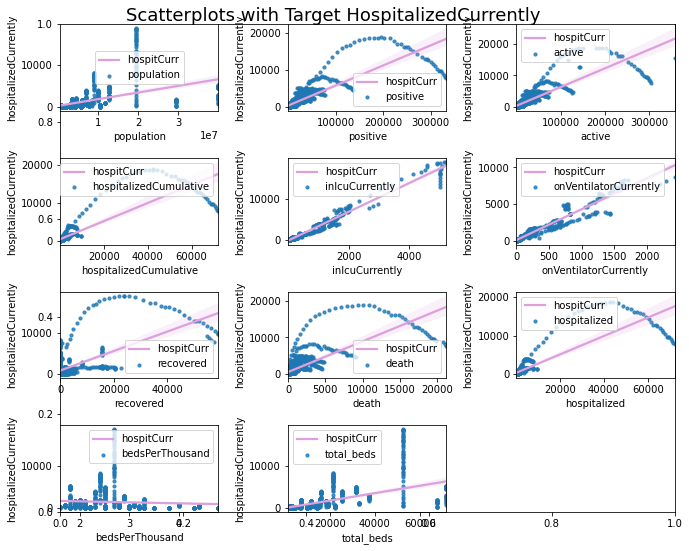

In [29]:
# Looking at linearity and variance with scatterplots
# Removing the target variable and saving it in another df
target = plot_df.hospitalizedCurrently
indep_var = plot_df.drop(columns=['hospitalizedCurrently'])

fig, ax = plt.subplots(figsize = (10, 8))
for i, col in enumerate(indep_var.columns):
    ax=fig.add_subplot(4, 3, i+1) 
    sns.regplot(x=indep_var[col], y=target, data=indep_var, label=col, scatter_kws={'s':10}, line_kws={"color": "plum", 'label': 'hospitCurr'})
    plt.suptitle('Scatterplots with Target HospitalizedCurrently', fontsize=18)
    plt.legend()
plt.tight_layout()
fig.subplots_adjust(top=0.95)

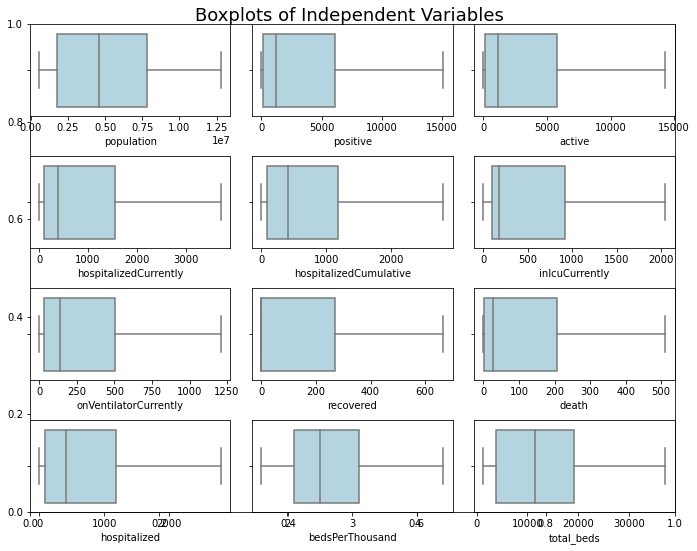

In [30]:
# Assessing the normality of the distribution with a boxplot
# Boxplot with removed outliers
fig, ax = plt.subplots(figsize = (10, 8))
for i, col in enumerate(plot_df.columns):
    ax=fig.add_subplot(4, 3, i+1) 
    sns.boxplot(x=plot_df[col], data=plot_df, color='lightblue', showfliers=False)
    plt.suptitle('Boxplots of Independent Variables', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

## New York and California Analysis
### Since the normality of the independent variables is highly questionable, we further assess the distribution by comparing two states (NY and CA) with eachother. 
We start with constructing scatter plots and boxplots of New York.

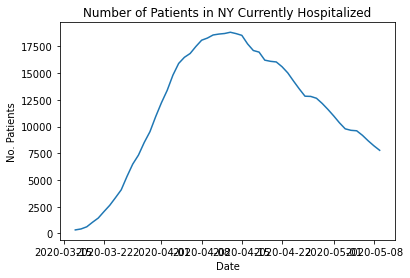

In [31]:
# Split all_cases into subset with only NY values
new_york = all_cases.loc[all_cases['abbrev'] == 'NY'] 

# Timeseries plt
plt.plot(new_york.date, new_york.hospitalizedCurrently)
plt.title('Number of Patients in NY Currently Hospitalized')
plt.xlabel('Date')
plt.ylabel('No. Patients')

# TODO the code below can be deleted once we fix the date format in plots
#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))

In [32]:
# Omit the categorical and date cols 
new_york = new_york[['positive', 'active', 'hospitalizedCurrently', 'hospitalizedCumulative', 'inIcuCurrently', 'recovered', 'death', 'hospitalized']]

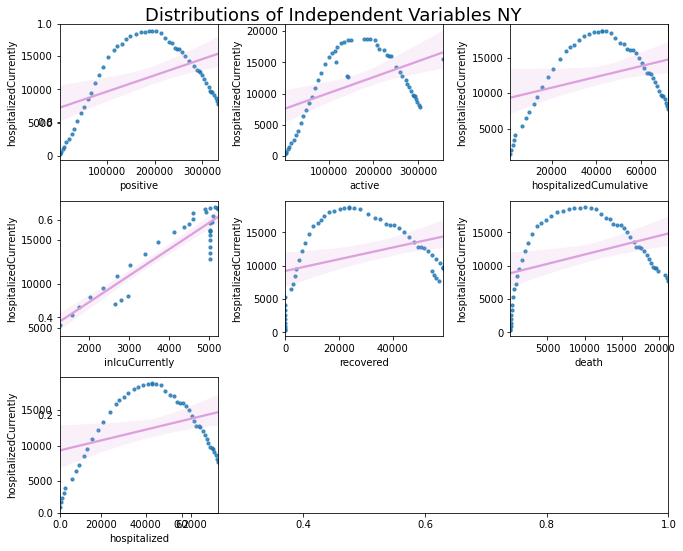

In [33]:
# Scatter plots NY
# Split dependent var from independent variables
target_ny = new_york.hospitalizedCurrently
indep_var_ny = new_york.drop(columns=['hospitalizedCurrently'])

fig, ax = plt.subplots(figsize = (10, 8))
for i, col in enumerate(indep_var_ny.columns):
    ax=fig.add_subplot(3, 3, i+1) 
    sns.regplot(x=indep_var_ny[col], y=target_ny, data=indep_var_ny, label=col, scatter_kws={'s':10}, line_kws={"color": "plum"})
    plt.suptitle('Distributions of Independent Variables NY', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(top=0.95)


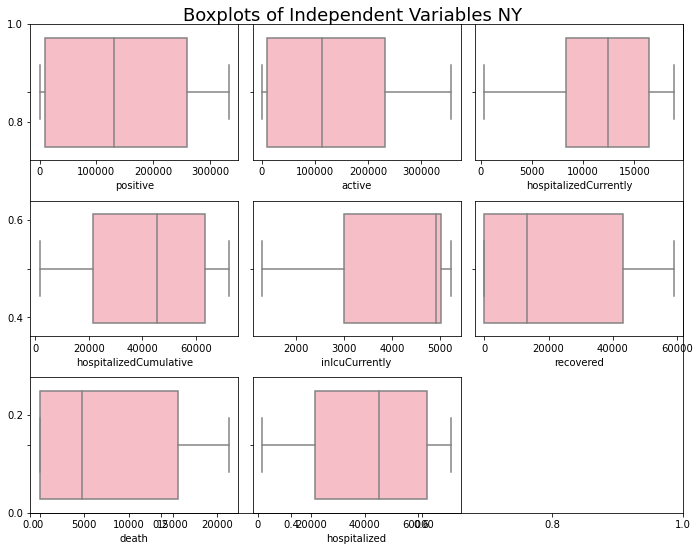

In [34]:
# Boxplot of NY
fig, ax = plt.subplots(figsize = (10, 8))
for i, col in enumerate(new_york.columns):
    ax=fig.add_subplot(3, 3, i+1) 
    sns.boxplot(x=new_york[col], data=new_york, color='lightpink', showfliers=True)
    plt.suptitle('Boxplots of Independent Variables NY', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

### Moving onto California:

In [35]:
cali = all_cases.loc[(all_cases['abbrev'] == 'CA') & (all_cases['state']== 'California')] 


Text(0, 0.5, 'No. Patients')

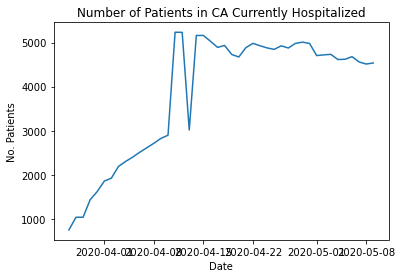

In [36]:
# TODO fix legend/axis/plot alltogether
# Timeseries plt
plt.plot(cali.date, cali.hospitalizedCurrently)
plt.title('Number of Patients in CA Currently Hospitalized')
plt.xlabel('Date')
plt.ylabel('No. Patients')

In [37]:
# Checking which cols have NaN values
cali[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death', 'hospitalized']]
cali.head()

# Omit the NaN cols
cali = cali[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'recovered', 'death']]

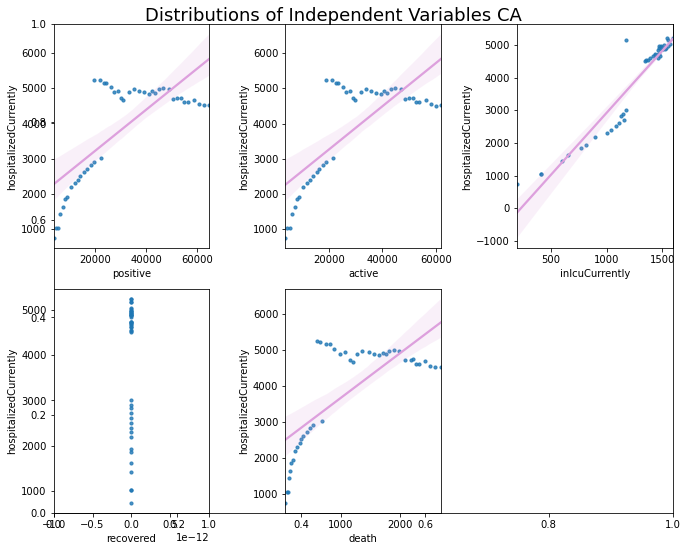

In [38]:
# Scatter plots CA
# Split dependent var from independent variables
target_ca = cali.hospitalizedCurrently
indep_var_ca = cali.drop(columns=['hospitalizedCurrently'])

fig, ax = plt.subplots(figsize = (10, 8))
for i, col in enumerate(indep_var_ca.columns):
    ax=fig.add_subplot(2, 3, i+1) 
    sns.regplot(x=indep_var_ca[col], y=target_ca, data=indep_var_ca, label=col, scatter_kws={'s':10}, line_kws={"color": "plum"})
    plt.suptitle('Distributions of Independent Variables CA', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

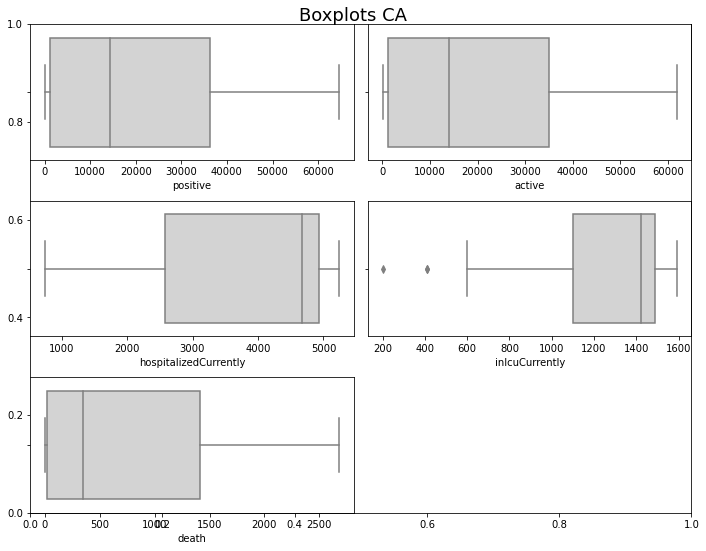

In [39]:
# Boxplot of CA
cali = cali[['positive', 'active', 'hospitalizedCurrently', 'inIcuCurrently', 'death']]
fig, ax = plt.subplots(figsize = (10, 8))
for i, col in enumerate(cali.columns):
    ax=fig.add_subplot(3, 2, i+1) 
    sns.boxplot(x=cali[col], data=cali, color='lightgrey', showfliers=True)
    plt.suptitle('Boxplots CA', fontsize=18)
plt.tight_layout()
fig.subplots_adjust(top=0.95)

## Assessing Correlation of Independent Variables

In [40]:
# TODO add some explanation / look more into collinear variables

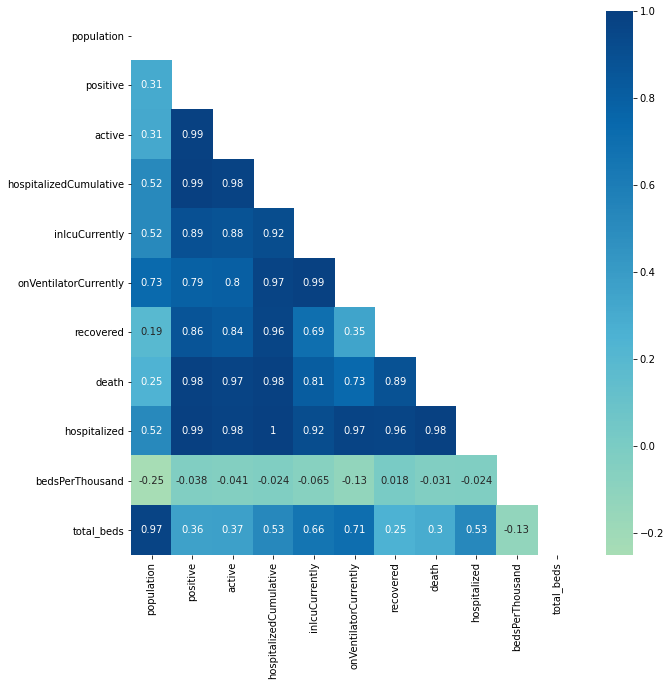

In [41]:
# Heatmap of correlations
# Save correlations to variable
corr = indep_var.corr()
# We can create a mask to not show duplicate values
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Generate heatmap
plt.figure(figsize= (10,10))
sns.heatmap(corr, annot=True, center=0, mask=mask, cmap='GnBu')
plt.show()

## Step 3: Build model for dependent Variable 
- To be used to predict hospitalizedCurrently
- Having more complete variables for inICUCurrently and onVentilatorCurrently will allow us to predict these numbers as well

In [52]:
# TODO check on normalising data

# We are going to compare three models:
# - Linear Regression
# - Polynomial Regression
# - ElasticNet

# Copy DFs to not mess up original one
# We will use model_df for our regression model
model_df = all_cases.copy()

# Delete redundant rows
for row in ['abbrev', 'bedsPerThousand', 'hospitalized', 
'state', 'hospitalizedCumulative', 'dataQualityGrade', 'lastUpdateEt']:
    del model_df[row]

# Drop NaN values for hospitalizedCurrently
model_df = model_df.dropna(subset=['hospitalizedCurrently'])

# Drop Values with low active-hospitalised ratio
# TODO see if we can instead use this as a variable
# TODO see if we can drop by bedsPerThousand instead
model_df['ratio_hospital'] = model_df['hospitalizedCurrently'] / model_df['active']
model_df = model_df[~(model_df['ratio_hospital'] <= model_df.ratio_hospital.quantile(0.35))]

#model_df = model_df[~(model_df['ratio_hospital'] <= model_df['ratio_hospital'].median())]
del model_df['ratio_hospital']

# Get peek of model to use
model_df.describe()

,population,positive,active,hospitalizedCurrently,inIcuCurrently,onVentilatorCurrently,recovered,death,total_beds
count,9.070000e+02,907.000000,907.000000,907.000000,502.000000,386.000000,907.000000,907.000000,907.000000
mean,8.294426e+06,17289.576626,15756.102536,1718.368247,698.195219,345.401554,1429.500551,784.503859,19201.303307
std,9.108106e+06,34361.320317,29355.541556,2989.836217,1033.170686,427.023521,4925.754799,1840.136556,18359.890127
min,6.280610e+05,115.000000,115.000000,11.000000,9.000000,4.000000,0.000000,0.000000,1318.928100
25%,3.179849e+06,1824.500000,1698.000000,201.000000,105.250000,37.000000,0.000000,49.500000,7126.154000
50%,5.845526e+06,5283.000000,5048.000000,637.000000,191.000000,188.500000,15.000000,205.000000,14019.138600
75%,8.936574e+06,19956.000000,18789.500000,1786.500000,1147.250000,558.750000,910.000000,713.000000,21447.777600
max,3.993749e+07,295106.000000,239257.000000,18825.000000,5225.000000,1705.000000,51673.000000,17638.000000,71887.480200


## One last thing:

Get all combinations of independent params

In [53]:
import itertools
split = 0.2

independent_cols = [x for x in list(model_df.columns) if not(x in ['hospitalizedCurrently', 'inIcuCurrently', 'onVentilatorCurrently', 'date'])]

comb_list = []
len_ind = len(independent_cols)
for i in range(len_ind):
    sub_list = list(itertools.combinations(independent_cols, len_ind-i))
    comb_list += list(list(x) for x in sub_list)

In [60]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def accuracy(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return 100 - mean_absolute_percentage_error(y_true, y_pred)

### Model 1: Polynomial Regression

In [87]:
from sklearn.metrics import r2_score

mse_df1 = {'param_comb': [],
'degree': [],
'score': [],
'mean_abs_err': [],
'r_squared': [],
'mape': [],
'accuracy (%)': []}

degrees = [i for i in range(2,8)]

for comb in comb_list:
    X = model_df[comb]
    y = model_df['hospitalizedCurrently']

    for d in degrees:

        polynomial_features = PolynomialFeatures(degree=d)
        x_poly = polynomial_features.fit_transform(X)

        model = LinearRegression()
        model.fit(x_poly, y)
        y_poly_pred = model.predict(x_poly)

        mse_df1['param_comb'].append(comb)
        mse_df1['score'].append(np.sqrt(mean_squared_error(y, y_poly_pred)))
        mse_df1['degree'].append(d)
        mse_df1['mean_abs_err'].append(mean_absolute_error(y, y_poly_pred))
        mse_df1['r_squared'].append(r2_score(y, y_poly_pred))
        mse_df1['mape'].append(mean_absolute_percentage_error(y, y_poly_pred))
        mse_df1['accuracy (%)'].append(accuracy(y, y_poly_pred))

mse_df1 = pd.DataFrame(mse_df1)
mse_df1.sort_values(by='r_squared', ascending=False).head()

,param_comb,degree,score,mean_abs_err,r_squared,mape,accuracy (%)
39,"[positive, active, recovered, death, total_beds]",5,255.414078,161.684885,0.992694,76.184140,23.815860
38,"[positive, active, recovered, death, total_beds]",4,300.633091,201.617880,0.989878,55.409341,44.590659
1,"[population, positive, active, recovered, deat...",3,307.873050,207.555759,0.989385,74.786115,25.213885
32,"[population, active, recovered, death, total_b...",4,338.644279,239.352683,0.987157,122.835790,-22.835790
2,"[population, positive, active, recovered, deat...",4,346.286998,252.144557,0.986571,130.075368,-30.075368


In [88]:
X = model_df[['positive', 'active', 'recovered', 'death', 'total_beds']]
y = model_df['hospitalizedCurrently']

polynomial_features = PolynomialFeatures(degree=4)
x_poly = polynomial_features.fit_transform(X)

model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)

### Model 2: Linear Regression

In [92]:
import itertools

mse_df = {'param_comb': [],
'score': [],
'mean_abs_err': [],
'r_squared': [],
'mape': [],
'accuracy (%)': []}

for comb in comb_list:
    # Independent vars
    X = model_df[comb]

    # Dependent var
    y = model_df['hospitalizedCurrently']

    # Fit model
    linear_model = LinearRegression()
    linear_model.fit(X, y)

    y_pred = linear_model.predict(X)
    
    mse_df['param_comb'].append(comb)
    mse_df['score'].append(np.sqrt((mean_squared_error(y, y_pred))))
    mse_df['mean_abs_err'].append(mean_absolute_error(y, y_pred))
    mse_df['mape'].append(mean_absolute_percentage_error(y, y_pred))
    mse_df['r_squared'].append(r2_score(y, y_pred))
    mse_df['accuracy (%)'].append(accuracy(y, y_pred))

mse_df = pd.DataFrame(mse_df)
mse_df.sort_values(by='r_squared', ascending=False).head()

,param_comb,score,mean_abs_err,r_squared,mape,accuracy (%)
0,"[population, positive, active, recovered, deat...",729.231635,403.749377,0.940445,51.758362,48.241638
1,"[population, positive, active, recovered, death]",729.778626,402.816719,0.940356,47.488891,52.511109
6,"[positive, active, recovered, death, total_beds]",730.123863,403.988240,0.940300,48.474050,51.525950
17,"[positive, active, recovered, death]",730.645527,407.784334,0.940214,55.380037,44.619963
3,"[population, positive, active, death, total_beds]",731.520526,410.079177,0.940071,56.523577,43.476423


### Model 3: ElasticNet Regression

Step 2: Cross-validate every combination (Look for best hyperparams first)

In [74]:
cross_val_results = {
    'columns': [],
    'alpha': [],
    'l1_ratio': []
}

for ind_cols in comb_list:
    X = model_df[ind_cols]
    y = model_df['hospitalizedCurrently']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split)

    # Seek best params like we seek the COVID vaccine
    elastic = ElasticNet(normalize=True, max_iter=5000)
    search=GridSearchCV(estimator=elastic,param_grid={
        'alpha':np.logspace(-5, 2, 8),
        'l1_ratio':[.1, .2, .4, .6, .75, .8, .85, .9, .95, 1]},
        scoring='neg_mean_absolute_error',
        n_jobs=1,
        refit=True,
        cv=10)

    search.fit(X_train,y_train)
    cross_val_results['columns'].append(ind_cols)
    cross_val_results['alpha'].append(search.best_params_['alpha'])
    cross_val_results['l1_ratio'].append(search.best_params_['l1_ratio'])

cross_val_results = pd.DataFrame(cross_val_results)

d:\dropbox\projects\results\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15040317.34145397, tolerance: 538306.5418845331
  positive)


In [95]:
score = []
mean_abs_err = []
map_err = []
r2_list = []
acc = []
for i, row in cross_val_results.iterrows():
    alpha = cross_val_results.at[i, 'alpha']
    l1 = cross_val_results.at[i, 'l1_ratio']

    X = model_df[cross_val_results.at[i, 'columns']]
    y = model_df['hospitalizedCurrently']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split)
    elastic = ElasticNet(normalize=True, alpha=alpha, l1_ratio=l1, max_iter=1000000)
    elastic.fit(X_train,y_train)

    rmse= (np.sqrt(mean_squared_error(y_true=y_test,y_pred=elastic.predict(X_test))))
    mae = mean_absolute_error(y_true=y_test, y_pred=elastic.predict(X_test))
    mape = (mean_absolute_percentage_error(y_test, elastic.predict(X_test)))
    r2 = r2_score(y_test, elastic.predict(X_test))
    accu = accuracy(y_test, elastic.predict(X_test))

    score.append(rmse)
    mean_abs_err.append(mae)
    map_err.append(mape)
    acc.append(accu)
    r2_list.append(r2)

cross_val_results['score'] = score
cross_val_results['mean_abs_err'] = mean_abs_err
cross_val_results['r_squared'] = r2_list
cross_val_results['mape'] = map_err
cross_val_results['accuracy (%)'] = acc

cross_val_results.sort_values(by='r_squared', ascending=False).head()

,columns,alpha,l1_ratio,score,mean_abs_err,mape,accuracy (%),r_squared
4,"[population, positive, recovered, death, total...",0.00001,0.60,856.729574,437.190841,75.184392,24.815608,0.950157
7,"[population, positive, active, recovered]",0.00010,0.85,679.235862,372.312763,48.677435,51.322565,0.948519
8,"[population, positive, active, death]",0.00001,0.40,855.202301,454.062689,66.022633,33.977367,0.945720
1,"[population, positive, active, recovered, death]",0.00010,0.85,818.895545,413.246149,57.334917,42.665083,0.942818
12,"[population, positive, death, total_beds]",0.00001,0.60,570.685623,331.289242,78.214694,21.785306,0.937426


### Decision Tree regression

## Step 4: Using findings from dataset of hospital beds, conclude research problem